In [5]:
#try:
  #%tensorflow_version 2.x
#except Exception:
  #pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from skimage.measure import label
from sklearn.utils import shuffle

2.6.4


**Data Exploration: Shipcount Histogram**

   Count     Count
0  26043  0.693223
1   9732  0.259050
2   1317  0.035056
3    357  0.009503
4     88  0.002342
5     23  0.000612
6      5  0.000133
8      2  0.000053
7      1  0.000027


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Count', ylabel='count'>

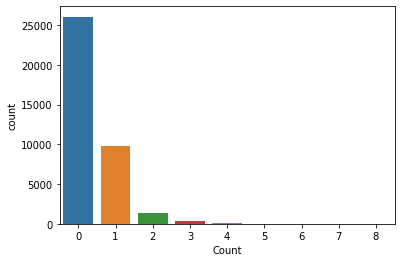

In [6]:
from sklearn.utils import shuffle

#df = pd.read_csv('train_ship_segmentations/train_ship_segmentations_v2.csv')
PATH = '/kaggle/input/airbus-ship-detection/'
df1 = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
df = shuffle(df1)
df.reset_index(drop=True)
df = df.iloc[0:40000]
#print(len(df['ImageId'].unique()), len([name for name in os.listdir(PATH + 'train_v2')]))

df['Count'] = df['EncodedPixels'].notnull()*1
df_h = df.groupby(['ImageId'])['Count'].sum()



print(pd.concat([df_h.value_counts(), df_h.value_counts(normalize=True)], axis=1))
sns.countplot(df_h)

**Removing corrupt images (size < 50 KB)**

37568
   Shipnum   Shipnum
0    25926  0.694937
1     9606  0.257485
2     1302  0.034900
3      355  0.009516
4       87  0.002332
5       23  0.000617
6        5  0.000134
8        2  0.000054
7        1  0.000027


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Shipnum', ylabel='count'>

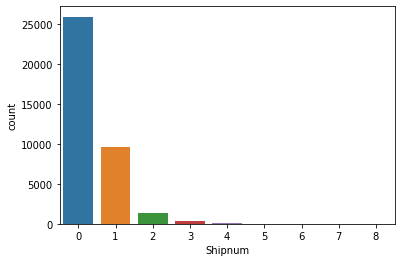

In [7]:
df_u = pd.DataFrame({'ImageId': df_h.index, 'Shipnum': df_h.values})
df_u['Filesize'] = df_u['ImageId'].apply(lambda x: os.path.getsize(PATH + 'train_v2/'+x)/1024)

print(df_u.shape[0])
df_u = df_u[df_u['Filesize'] > 50]
#print(df_u.shape[0])

print(pd.concat([df_u['Shipnum'].value_counts(), df_u['Shipnum'].value_counts(normalize=True)], axis=1))
sns.countplot(df_u['Shipnum'])

# import shutil
# os.makedirs('50-60')
# for index, row in df_u.iterrows():
#   if row['Filesize'] < 60 and row['Filesize'] >= 50:
#     shutil.copy('train/'+row['ImageId'], '50-60')
#   else:
#     pass
  
# !zip -r 50-60.zip 50-60
# !rm -rf 50-60

In [10]:
train_df, test_df = train_test_split(df_u, test_size=0.2, random_state=7)  #, stratify=df_u['Shipnum']
print(train_df.shape[0], test_df.shape[0])

29845 7462


**Figuring out cutoff threshold required for balancing the imbalanced dataset**

In [11]:
print(train_df['Shipnum'].value_counts().median(), train_df['Shipnum'].value_counts().mean(), np.quantile(train_df['Shipnum'].value_counts(), 0.75))
print(train_df['Shipnum'].max())

175.5 3730.625 2696.75
7


**Balancing the training dataset**

1500 2910
****************************************************************************************************
   Shipnum   Shipnum
0     1500  0.340136
1     1500  0.340136
2     1037  0.235147
3      278  0.063039
4       73  0.016553
5       17  0.003855
6        4  0.000907
7        1  0.000227


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Shipnum', ylabel='count'>

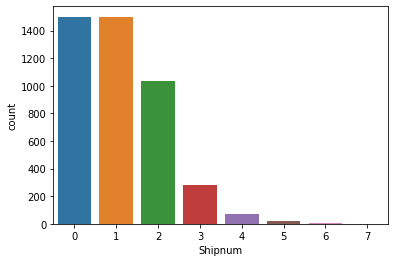

In [12]:
cutoff = 1500

balanced_train_df = pd.DataFrame(columns = train_df.columns)

for i in range(0, 16):
  if train_df[train_df['Shipnum']==i].shape[0] > cutoff:
    balanced_train_df = balanced_train_df.append(train_df[train_df['Shipnum']==i].sample(cutoff, random_state=7))
  else:
    balanced_train_df = balanced_train_df.append(train_df[train_df['Shipnum']==i])
    
print(balanced_train_df[balanced_train_df['Shipnum']==0].shape[0], balanced_train_df[balanced_train_df['Shipnum']>0].shape[0])
print('*'*100)
print(pd.concat([balanced_train_df['Shipnum'].value_counts(), balanced_train_df['Shipnum'].value_counts(normalize=True)], axis=1))
sns.countplot(balanced_train_df['Shipnum'])

**RLE Encode & Decode Methods**

In [13]:
image_height = 768
image_width = 768

def rle_decode(img_id):
  img_rle = [*df.loc[df['ImageId']==img_id]['EncodedPixels']]
  mask = np.zeros(image_height*image_width, dtype=np.uint8)
  if df_u.iloc[list(df_u['ImageId']==img_id).index(True)]['Shipnum']!=0:
    for x in img_rle:
      x = x.split(' ')
      for i in range(0, len(x), 2):
        mask[int(x[i]):int(x[i])+int(x[i+1])]=1
  return mask.reshape(image_height, image_width).astype(np.float32).T

def rle_multi_encode(mask):
  mask, labelnum = label(mask, return_num=True)
  if labelnum==0:
    return [np.nan]
  return [rle_encode(mask==k) for k in range(1, labelnum+1)]

def rle_encode(mask):
  mask = mask.T.flatten()
  mask = np.concatenate([[0], mask, [0]])
  idx = np.where(mask[1:]!=mask[:-1])[0]
  idx[1::2] -= idx[:-1:2]
  return ' '.join([str(x) for x in idx])

**RLE Encode Check**

In [14]:
img_id = '02776139a.jpg'

# print(df_u[df_u['Shipnum']==15])

print(rle_multi_encode(rle_decode(img_id)))
print([*df.loc[df['ImageId']==img_id]['EncodedPixels']])
print(len(rle_multi_encode(rle_decode(img_id))), len([*df.loc[df['ImageId']==img_id]['EncodedPixels']]))

['212470 3 213238 8 214006 13 214774 16 215541 17 216309 17 217077 17 217845 16 218613 16 219381 16 220148 17 220916 17 221684 17 222455 13 223228 8 224001 3']
['212470 3 213238 8 214006 13 214774 16 215541 17 216309 17 217077 17 217845 16 218613 16 219381 16 220148 17 220916 17 221684 17 222455 13 223228 8 224001 3']
1 1


**RLE Decode Check**

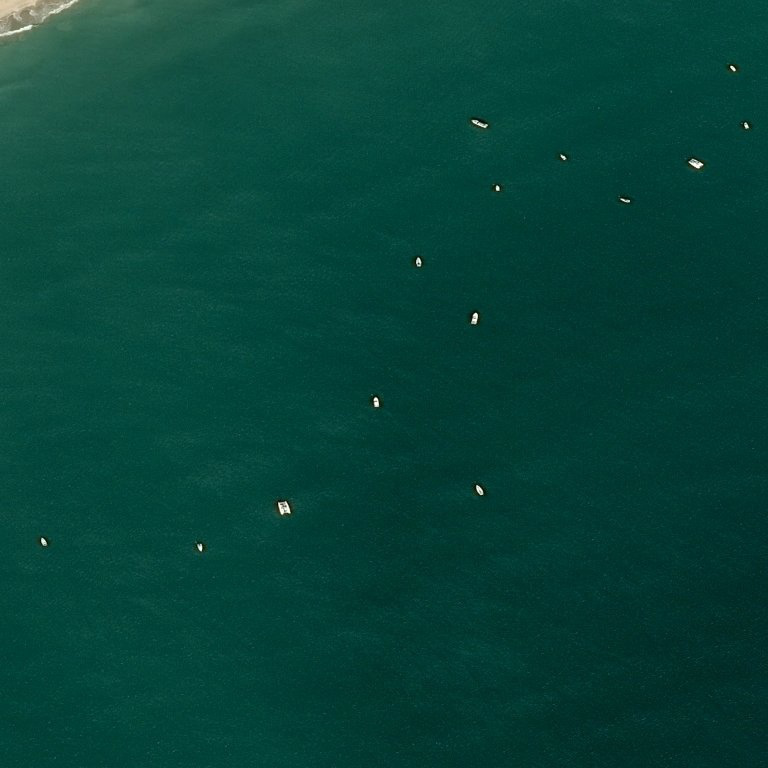

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=768x768>

In [15]:
from IPython.display import display

# print(df_u[df_u['Shipnum']==15])

img = Image.open(PATH+'/train_v2/02776139a.jpg')
display(img)

img1 = Image.fromarray(rle_decode('02776139a.jpg')*255)
display(img1)

**RLE Decode Check2 - Image & Mask Superimposition**

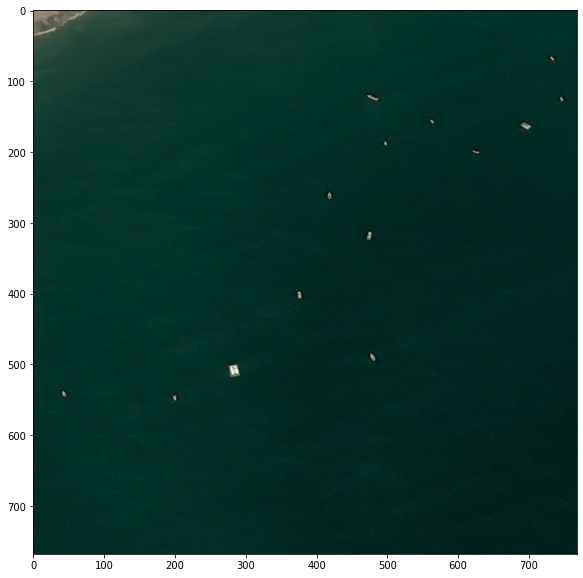

In [16]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(img1, cmap='gray', alpha=0.3)

**Created Custom Train Data Generator with Data Augmentation**



(32, 768, 768, 3) (32, 768, 768, 1)
0.0 0.99997735 0.0 1.0 [0.         0.00217108 0.00296478 0.01435694 0.018653   0.01939596
 0.02918678 0.05352207 0.06708142 0.07186541 0.07829092 0.08523617
 0.11324396 0.15803534 0.16213681 0.16960606 0.19900355 0.20853697
 0.20954107 0.21514875 0.21600583 0.22176054 0.23573036 0.23856667
 0.23863119 0.33697507 0.3534477  0.36234874 0.4194708  0.42608258
 0.43269438 0.43930617 0.44181302 0.44591796 0.45097214 0.45252976
 0.45914155 0.46575335 0.47634584 0.50039977 0.5017195  0.5080198
 0.51653385 0.5186892  0.5203312  0.52682376 0.5270932  0.53055745
 0.55246687 0.5559311  0.5564599  0.5813048  0.58921814 0.5936182
 0.6156569  0.6178437  0.6610495  0.6702173  0.6768291  0.68344086
 0.6900527  0.7194861  0.7199007  0.775523   0.78019375 0.792343
 0.874828   0.88570255 0.894231   0.8945303  0.91475755 0.9228476
 0.92945945 0.9334803  0.9360712  0.9389673  0.94268304 0.96527505
 0.96623504 0.9998454  1.        ]


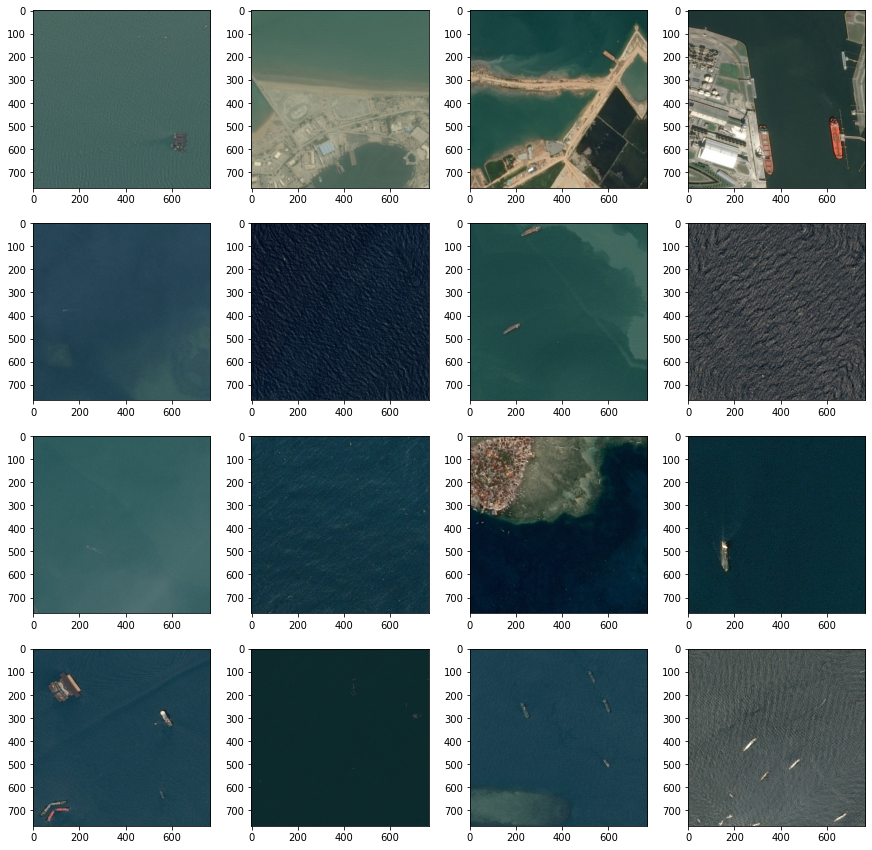

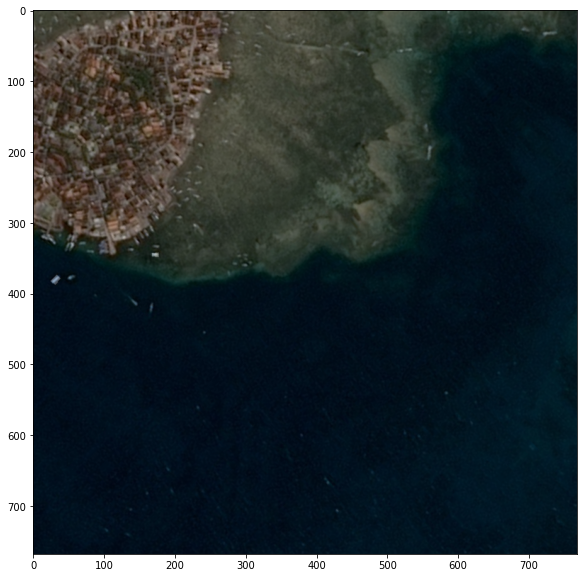

In [17]:
bs = 32

def train_data_gen(train_df):
  train_df = shuffle(train_df, random_state=7).reset_index(drop=True)
  x_train = []
  y_train = []
  for index, row in train_df.iterrows():
    x_train.append(np.asarray(Image.open(PATH+'/train_v2/'+row['ImageId']), dtype=np.float32))
    y_train.append(rle_decode(row['ImageId']))
    if len(x_train)>=bs:
      yield np.stack(x_train, axis=0), np.stack(y_train, axis=0).reshape(-1, image_height, image_width, 1)
      x_train = []
      y_train = []

x_train_aug_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.01, 
                                     zoom_range=0.1, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)

y_train_aug_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.01, 
                                        zoom_range=0.1, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)

SEED = 7

def train_gen(train_df):
  for x_train, y_train in train_data_gen(train_df):
    X_TRAIN = x_train_aug_gen.flow(x_train, batch_size=x_train.shape[0], seed=SEED)
    Y_TRAIN = y_train_aug_gen.flow(y_train, batch_size=y_train.shape[0], seed=SEED)
    yield next(X_TRAIN)/255.0, next(Y_TRAIN)

x_train, y_train = next(train_gen(balanced_train_df))
print(x_train.shape, y_train.shape)

fig1 = plt.figure(figsize=(15, 15))
for i in range(1, 17):
  fig1.add_subplot(4, 4, i)
  plt.imshow(x_train[i])

id = 11
print(x_train[id].min(), x_train[id].max(), y_train[id].min(), y_train[id].max(), np.unique(y_train[id]))
fig2 = plt.figure(figsize=(10,10))
plt.imshow(x_train[id])
plt.imshow(Image.fromarray(y_train[id].reshape(image_height, image_width)*255), cmap='gray', alpha=0.3)
plt.show()

**Created Custom Test Data Generator**

(32, 768, 768, 3) (32, 768, 768, 1)
0.44313726 1.0 0.0 1.0 [0. 1.]


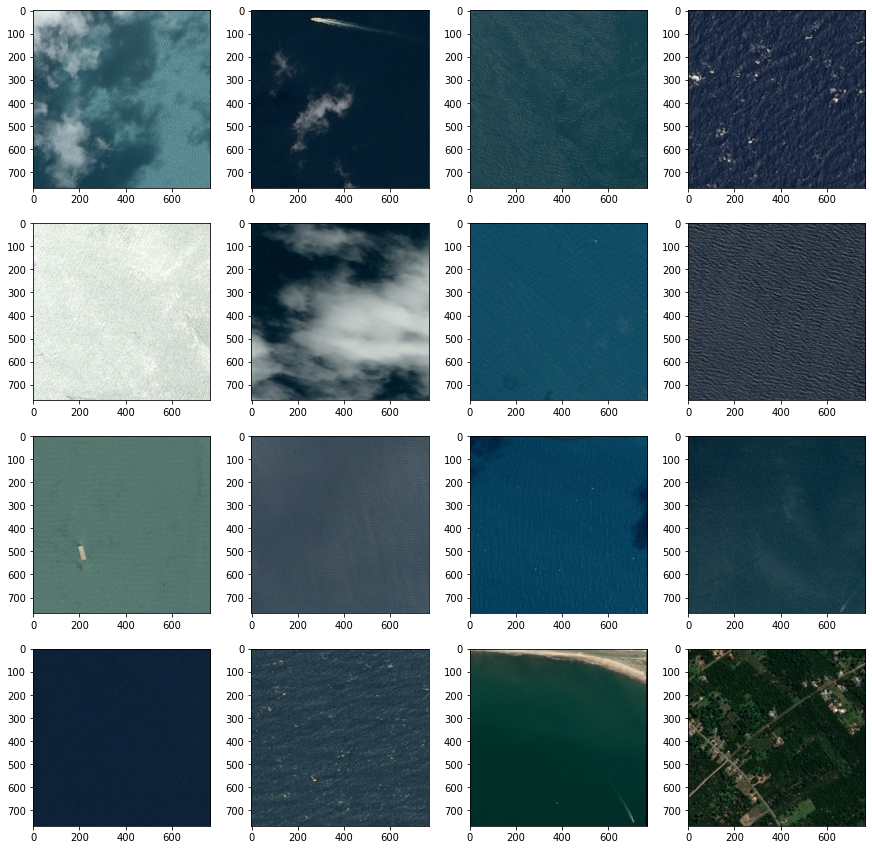

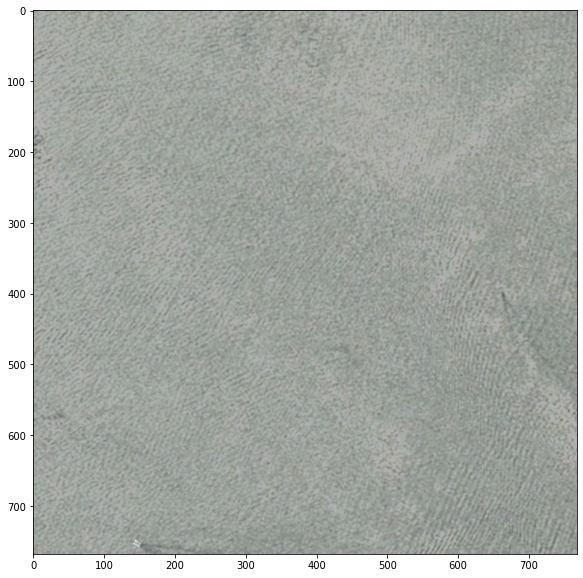

In [18]:
bs1 = 32

def test_data_gen(test_df):
  test_df = shuffle(test_df, random_state=7).reset_index(drop=True)
  x_test = []
  y_test = []
  for index, row in test_df.iterrows():
    x_test.append(np.asarray(Image.open(PATH+'/train_v2/'+row['ImageId']), dtype=np.float32))
    y_test.append(rle_decode(row['ImageId']))
    if len(x_test)>=bs1:
      yield np.stack(x_test, axis=0)/255.0, np.stack(y_test, axis=0).reshape(-1, image_height, image_width, 1)
      x_test = []
      y_test = []

x_test, y_test = next(test_data_gen(test_df))
print(x_test.shape, y_test.shape)

fig1 = plt.figure(figsize=(15, 15))
for i in range(1, 17):
  fig1.add_subplot(4, 4, i)
  plt.imshow(x_test[i])

id = 5
print(x_test[id].min(), x_test[id].max(), y_test[id].min(), y_test[id].max(), np.unique(y_test[id]))
fig2 = plt.figure(figsize=(10,10))
plt.imshow(x_test[id])
plt.imshow(Image.fromarray(y_test[id].reshape(image_height, image_width)*255), cmap='gray', alpha=0.3)
plt.show()

**Creating Data Generator Instances**

In [19]:
train_gen_i = train_gen(balanced_train_df)
test_data_gen_i = test_data_gen(test_df)

**Custom Loss Function for Image Segmentation Task**

In [20]:
def dice_coeff(target, pred):
  smooth = 1.0
  intersection = K.sum(target * pred, axis=[1,2,3])
  union = K.sum(target, axis=[1,2,3]) + K.sum(pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
  # return ((2*((pred*target).sum()))+smooth) / (pred.sum()+target.sum()+smooth)

def loss(target, pred):
  bce = binary_crossentropy(target, pred)
  dice_loss = 1-dice_coeff(target, pred)
  return bce-tf.math.log(1-dice_loss)

**U-Net Architecture (not exact but similar)**

In [21]:
img = layers.Input((image_height, image_width, 3))

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (img)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = layers.UpSampling2D((2, 2)) (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = layers.UpSampling2D((2, 2)) (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = layers.UpSampling2D((2, 2)) (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = layers.UpSampling2D((2, 2)) (c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

o = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same') (c9)

U_Net = models.Model(inputs=[img], outputs=[o])
U_Net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 384, 384, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [22]:
U_Net.compile(optimizer='adam', loss=loss, metrics=[dice_coeff, 'binary_accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
steps_per_epoch=2
validation_steps=2
epoch_num = 5
history = U_Net.fit_generator(train_gen_i, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, 
                              epochs=epoch_num, validation_data=test_data_gen_i, callbacks=[mc])



/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2/2 [==============================] - 34s 8s/step - loss: 5.6580 - dice_coeff: 0.0071 - binary_accuracy: 0.7451 - val_loss: 7.1744 - val_dice_coeff: 0.0016 - val_binary_accuracy: 0.9960
Epoch 2/5
2/2 [==============================] - 17s 13s/step - loss: 5.9853 - dice_coeff: 0.0058 - binary_accuracy: 0.9939 - val_loss: 7.4597 - val_dice_coeff: 0.0015 - val_binary_accuracy: 0.9982
Epoch 3/5
2/2 [==============================] - 18s 14s/step - loss: 5.8832 - dice_coeff: 0.0062 - binary_accuracy: 0.9956 - val_loss: 6.7486 - val_dice_coeff: 0.0023 - val_binary_accuracy: 0.9988
Epoch 4/5
2/2 [==============================] - 18s 14s/step - loss: 5.9641 - dice_coeff: 0.0042 - binary_accuracy: 0.9976 - val_loss: 7.1802 - val_dice_coeff: 9.0837e-04 - val_binary_accuracy: 0.9995
Epoch 5/5
2/2 [==============================] - 18s 15s/step - loss: 5.8869 - dice_coeff: 0.0031 - binary_accuracy: 0.9981 - val_loss: 7.0377 - val_dice_coeff: 0.0011 - val_binary_accuracy: 0.9993


NameError: name 'U_net' is not defined

In [24]:
U_Net.save("/kaggle/working/model1.h5")